In [1]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
import LearningCutsUtils.Utils as LCU
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.Utils)

<module 'LearningCutsUtils.Utils' from '/home/mhance/NN-For-Cuts/LearningCutsUtils/Utils.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars

In [8]:
import pandas as pd

In [46]:
filepath='/data/mhance/SUSY/Compressed/'
filebase='SusySkimSlep_v0.2_SlepSignals__'
filename='MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_%dp0_%dp0_NoSys' % (mass,mass-split)
filesuff='.hf5'
fullname=filepath+filebase+filename+filesuff

# , columns=['lep1MT_Met', 'lep2MT_Met', 'met_Et','Rll']
df1 = pd.read_hdf(fullname, key='MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_200p0_170p0_NoSys')
print(df1)
branches=['lep1MT_Met', 'lep2MT_Met', 'met_Et','Rll','Rll']
df1 = df1[branches].to_numpy()
print(df1)
num_sig_events = len(df1)

#print(np.expand_dims(df1[:,-1],1))

        lep1Flavor  lep1Charge     lep1Pt   lep1Eta   lep1Phi  lep1MT_Met  \
0              2.0         1.0  44.742554 -0.131429 -2.023897  122.828758   
1              2.0        -1.0  76.298767  0.581531 -1.627870  119.650734   
2              2.0         1.0  76.166962 -0.886471  2.539258  214.657242   
3              2.0         1.0  93.633484 -0.732073  0.121365  285.984985   
4              2.0         1.0  41.499908 -0.104845 -0.393813   20.230570   
...            ...         ...        ...       ...       ...         ...   
251101         2.0        -1.0  67.306381  0.256974 -1.822900   12.705248   
251102         2.0         1.0  80.271057 -0.227875 -0.092985   16.129774   
251103         2.0        -1.0  60.450851 -1.281938 -1.041315  231.667404   
251104         2.0         1.0  47.790604  0.116259 -2.522010  135.745102   
251105         1.0        -1.0  61.399975 -0.242621 -0.696941  206.678375   

        lep1_DPhiMet  lep1Signal  lep2Flavor  lep2Charge  ...   met_Phi  \


In [85]:
x=None
y=None

N=0 # number of points
m=0 # dimensions

if False:
    # array of means and widths for gaussians,
    # indices are:
    # - number of dimensions
    # - signal (0) vs background (1)
    # - mean (0) vs width (1)

    N=20000 # number of points
    m=10 # dimensions
    
    np.random.seed(123)
    width_scale_factor=2.
    mean_scale_factor=1.
    
    # if we want more control over the function, for example
    means_widths=[[[4,0.4],
                   [-2,.10]],
                  [[3,1.0],
                   [-1,0.5]]]
    
    means_widths=np.random.randn(m,2,2)               
    
    # now construct the training data.  after taking transpose, should be N rows by m columns.  
    x_signal=np.array([mean_scale_factor*means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
    y_signal=np.ones(N)
    x_backgr=np.array([mean_scale_factor*means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
    y_backgr=np.zeros(N)
    x=np.concatenate((x_signal,x_backgr))
    y=np.concatenate((y_signal,y_backgr))
else:
    # Prep Data using Pandas
    x_sig_data=None
    y_sig_data=None
    
    x_bkg_data=None
    y_bkg_data=None
    
    num_sig_events=0
    num_bkg_events=0
    
    # Need to copy the last branch, Rll, so that we have a total of 5 branches
    branches=[
        'lep1Pt','lep1Eta','lep1Phi','lep1MT_Met','lep1_DPhiMet',
        'lep2Pt','lep2Eta','lep2Phi','lep2MT_Met','lep2_DPhiMet',
        'met_Et','met_Phi',
        'Rll',
    #    'nJet30','mt2leplsp_100'
    ]
    
    # open signal
    mass=200
    split=30
    filepath='/data/mhance/SUSY/Compressed/'
    filebase='SusySkimSlep_v0.2_SlepSignals__'
    filename='MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_%dp0_%dp0_NoSys' % (mass,mass-split)
    filesuff='.hf5'
    
    # Makes data frame for signal events
    fullname=filepath+filebase+filename+filesuff
    df = pd.read_hdf(fullname, key=filename)
    df1 = df[branches].to_numpy()
    num_sig_events = len(df1)
    x_signal = df1
    y_signal = np.ones(num_sig_events)
    print("Extracted %7d signal events" % num_sig_events)
    
    fullname=filepath+"SusySkimSlep_v0.2_diboson2L__diboson2L_NoSys"+filesuff
    df = pd.read_hdf(fullname, key='diboson2L_NoSys')
    df2 = df[branches].to_numpy()
    num_bkg_events = len(df2)
    x_backgr = df2
    y_backgr=np.zeros(num_bkg_events)
    print("Extracted %7d background events" % num_bkg_events)    

    
    if num_bkg_events>num_sig_events:
        x = np.concatenate((x_signal,x_backgr[:num_sig_events]))
        y = np.concatenate((y_signal,y_backgr[:num_sig_events]))
        N=2*num_bkg_events
    else:
        x = np.concatenate((x_signal[:num_bkg_events],x_backgr))
        y = np.concatenate((y_signal[:num_bkg_events],y_backgr))
        N=2*num_sig_events
    m=len(branches)

Extracted  251106 signal events
Extracted  126906 background events


In [86]:
print(x_signal.shape)

(251106, 13)


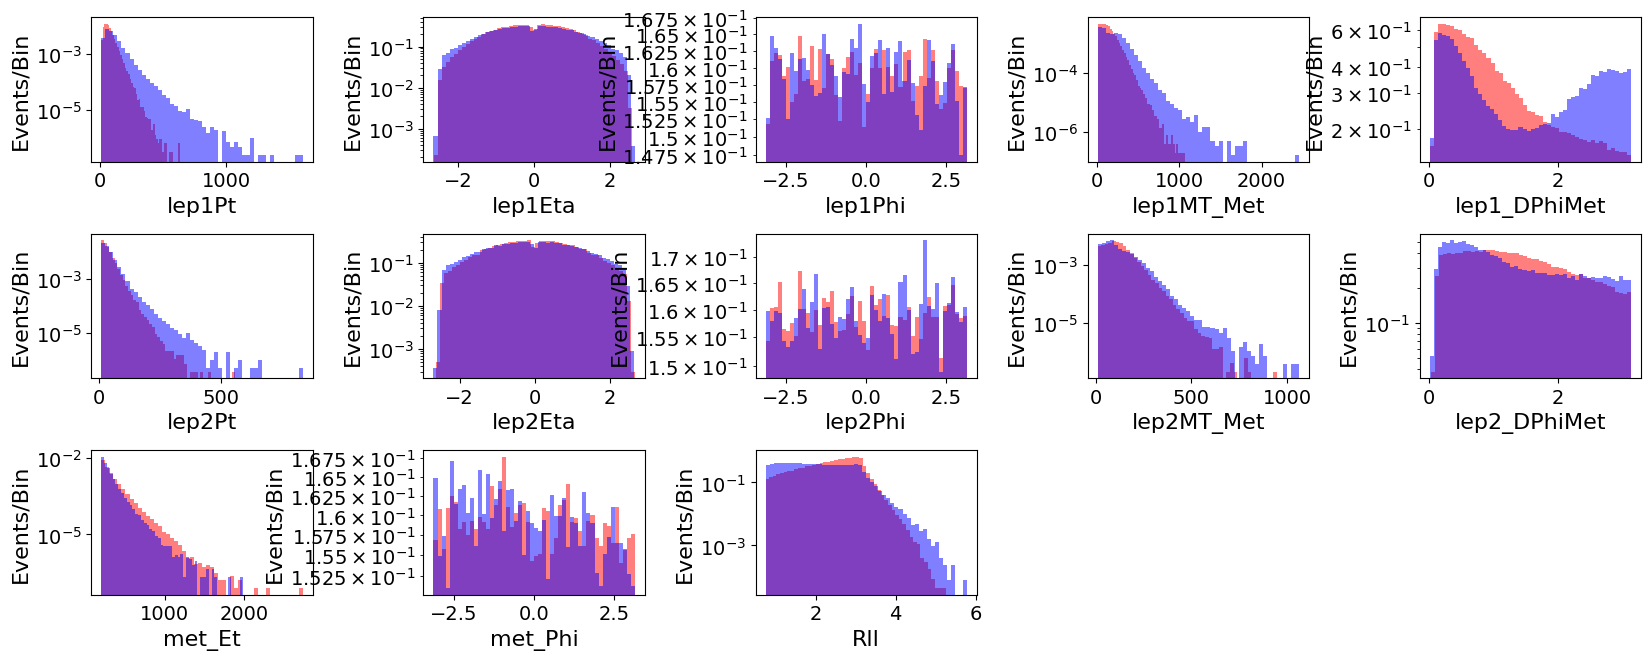

In [87]:
fig = plt.figure(figsize=(20,2.5*(int(m/5)+1)))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(int(m/5)+1,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"{branches[b]}")
    ax.set_ylabel("Events/Bin")
    plt.savefig("features_dummy.pdf")

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [89]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [102]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=200

In [103]:
torch.manual_seed(123)

net=None

simplenet=False
if simplenet:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 1,bias=False),
        torch.nn.Sigmoid()
    )
else:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid()
    )

torch.save(net.state_dict(), 'net_FC_untrained.pth')
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [104]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_FC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = net(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.data)

    # configure the model for evaluation (testing)
    net.eval()
    
    y_pred = net(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(net.state_dict(), 'net_FC_trained.pth')

Completed epoch  0 in  4.9s, Train loss=7.0e-01, Test loss=6.7e-01
Completed epoch  1 in  4.9s, Train loss=6.7e-01, Test loss=6.5e-01
Completed epoch  2 in  4.4s, Train loss=6.5e-01, Test loss=6.2e-01
Completed epoch  3 in  5.3s, Train loss=6.2e-01, Test loss=5.8e-01
Completed epoch  4 in  4.4s, Train loss=5.8e-01, Test loss=5.8e-01
Completed epoch  5 in  4.2s, Train loss=5.8e-01, Test loss=5.6e-01
Completed epoch  6 in  5.1s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch  7 in  4.9s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch  8 in  4.3s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch  9 in  5.0s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 10 in  4.3s, Train loss=5.5e-01, Test loss=5.4e-01
Completed epoch 11 in  4.2s, Train loss=5.4e-01, Test loss=5.4e-01
Completed epoch 12 in  4.8s, Train loss=5.4e-01, Test loss=5.3e-01
Completed epoch 13 in  5.0s, Train loss=5.3e-01, Test loss=5.3e-01
Completed epoch 14 in  5.1s, Train loss=5.3e-01, Test loss=5.2

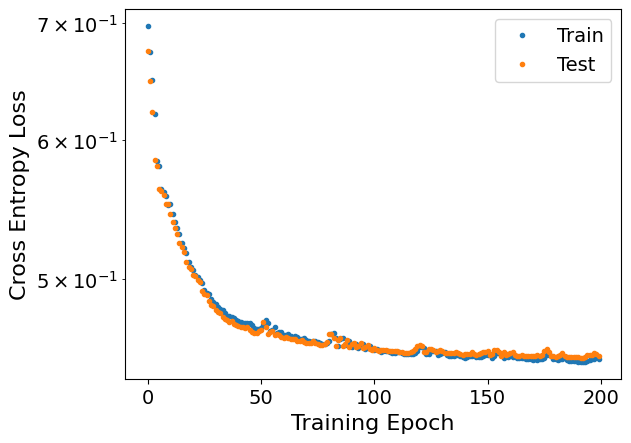

In [105]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

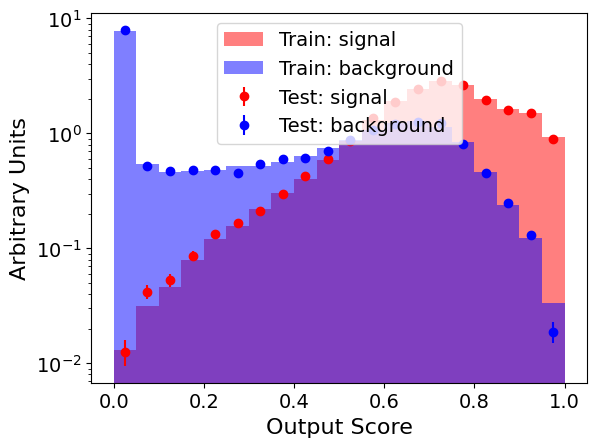

In [106]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = net(x_test_tensor).detach().cpu()
y_pred_train= net(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_FC_dummy.pdf")

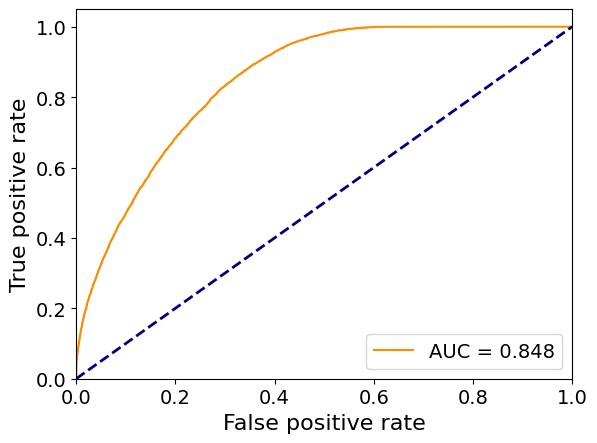

In [107]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_FC_dummy.pdf")

In [59]:
net[0].weight

Parameter containing:
tensor([[-0.7354, -0.2431,  0.4707,  0.5692,  0.0195]], requires_grad=True)

In [60]:
net[0].bias

In [61]:
if net[0].bias is not None:
    -net[0].bias/net[0].weight

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net[0].bias.detach().numpy()
    weights=net[0].weight.detach().numpy()
    scaled_cuts=-biases/weights
    
    cuts=sc.inverse_transform(scaled_cuts)[0]
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[0][b] < 0:
            ax.axvline(x = cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = cuts[b], color='y') # cut is "greater than"

It's clear that this super-simple network does slightly better than the fully-connected network that I set up.  Not
significantly better, but noticeably.  I don't see an obvious reason for why, aside from noting that a number of signal events in the OneToOneLinear network trained with a BCE loss function have ~0 output scores, while that's not the case in this setup.  I suspect that has to do with taking the product of feature scores to derive the final discriminant, as opposed to the sum as in the simple linear network.  I don't think that's something that can change.

Will be interesting to see how this compares for the slepton/diboson dataset.

Overall I think this is still hanging together, and I can present a progression of NN's:
* Fully connected with BCE
* OneToOneLinear with BCE
* OneToOneLinear with custom losses

Do those all with nominal, and then vary the test data inputs within some uncertainties and check to see the results on signal efficiency and background rejection.  Then test on slepton/diboson.  That's a solid paper right there, I'd say, and can be the starting point for Scott/Earl using this for photons.

Here we test.

In [19]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, net, net[0].weight[0], 0.95)

Output threshold for 95.0% efficiency: 0.45429617166519165 gives 95.0%

Signal efficiency for nominal, output>0.45429617166519165: 0.9496761335326358
Signal efficiency for noisy  , output>0.45429617166519165: 0.9344793223716991

Backgr efficiency for nominal, output>0.45429617166519165: 0.0027596588058203713
Backgr efficiency for noisy  , output>0.45429617166519165: 0.007275464124435524

Output threshold for 95.0% efficiency if trained on noisy data: 0.35773739218711853 gives 95.0%
